In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import os
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
import numpy as np
from bs4 import BeautifulSoup 

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## 데이터 수집

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


## 데이터 전처리

In [4]:
# 중복 문장을 제거합니다.
data = data.drop_duplicates()

# 특수 문자를 제거합니다.
data['text'] = data['text'].str.replace('[^\w\s]', '')

# 불용어를 제거합니다.
stopwords = nltk.corpus.stopwords.words('english')
data['text'] = data['text'].str.replace(' '.join(stopwords), '')

# 단어를 소문자로 변환합니다.
data['text'] = data['text'].str.lower()

# 단어를 토큰화합니다.
data['tokens'] = data['text'].str.split()

/tmp/ipykernel_174/4216119502.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('[^\w\s]', '')


In [5]:
# 중복 문장을 제거합니다.

# 특수 문자를 제거합니다.
data['headlines'] = data['headlines'].str.replace('[^\w\s]', '')

# 불용어를 제거합니다.
stopwords = nltk.corpus.stopwords.words('english')
data['headlines'] = data['headlines'].str.replace(' '.join(stopwords), '')

# 단어를 소문자로 변환합니다.
data['headlines'] = data['headlines'].str.lower()

# 단어를 토큰화합니다.
data['tokens_target'] = data['headlines'].str.split()

/tmp/ipykernel_174/725207787.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['headlines'] = data['headlines'].str.replace('[^\w\s]', '')


In [6]:
print(data.isnull().sum())

headlines        0
text             0
tokens           0
tokens_target    0
dtype: int64


In [7]:
data.head()

,headlines,text,tokens,tokens_target
0,upgrad learner switches to career in ml al wi...,saurav kant an alumnus of upgrad and iiitbs pg...,"[saurav, kant, an, alumnus, of, upgrad, and, i...","[upgrad, learner, switches, to, career, in, ml..."
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,"[kunal, shahs, credit, card, bill, payment, pl...","[delhi, techie, wins, free, food, from, swiggy..."
2,new zealand end rohit sharmaled indias 12match...,new zealand defeated india by 8 wickets in the...,"[new, zealand, defeated, india, by, 8, wickets...","[new, zealand, end, rohit, sharmaled, indias, ..."
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,"[with, aegon, life, iterm, insurance, plan, cu...","[aegon, life, iterm, insurance, plan, helps, c..."
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,"[speaking, about, the, sexual, harassment, all...","[have, known, hirani, for, yrs, what, if, meto..."


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.22309639252279
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.550666300734912


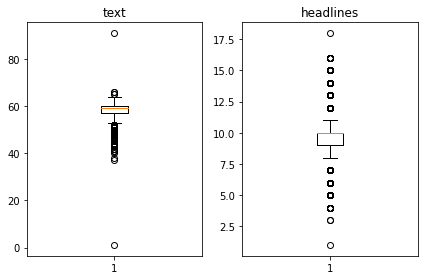

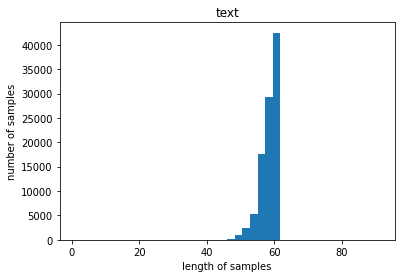

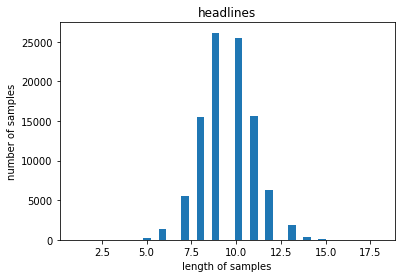

In [8]:
# data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data_prepro.csv", nrows=100000)

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
text_max_len = 60
summary_max_len = 12
print('=3')

=3


## 어텐션 메커니즘 사용하기

In [10]:
data['decoder_input'] = data['text'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['text'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,tokens,tokens_target,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wi...,saurav kant an alumnus of upgrad and iiitbs pg...,"[saurav, kant, an, alumnus, of, upgrad, and, i...","[upgrad, learner, switches, to, career, in, ml...",sostoken saurav kant an alumnus of upgrad and ...,saurav kant an alumnus of upgrad and iiitbs pg...
1,delhi techie wins free food from swiggy for on...,kunal shahs credit card bill payment platform ...,"[kunal, shahs, credit, card, bill, payment, pl...","[delhi, techie, wins, free, food, from, swiggy...",sostoken kunal shahs credit card bill payment ...,kunal shahs credit card bill payment platform ...
2,new zealand end rohit sharmaled indias 12match...,new zealand defeated india by 8 wickets in the...,"[new, zealand, defeated, india, by, 8, wickets...","[new, zealand, end, rohit, sharmaled, indias, ...",sostoken new zealand defeated india by 8 wicke...,new zealand defeated india by 8 wickets in the...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,"[with, aegon, life, iterm, insurance, plan, cu...","[aegon, life, iterm, insurance, plan, helps, c...",sostoken with aegon life iterm insurance plan ...,with aegon life iterm insurance plan customers...
4,have known hirani for yrs what if metoo claims...,speaking about the sexual harassment allegatio...,"[speaking, about, the, sexual, harassment, all...","[have, known, hirani, for, yrs, what, if, meto...",sostoken speaking about the sexual harassment ...,speaking about the sexual harassment allegatio...


In [11]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [12]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [13]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19675


In [14]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78704
훈련 레이블의 개수 : 78704
테스트 데이터의 개수 : 19675
테스트 레이블의 개수 : 19675


In [15]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [16]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 107130
등장 빈도가 6번 이하인 희귀 단어의 수: 81771
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25359
단어 집합에서 희귀 단어의 비율: 76.32875945113413
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.19236463565591


In [17]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [18]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 501, 86, 7, 111, 259, 3, 721, 1222, 1, 2141, 5, 3, 1825, 1142, 46, 1, 235, 63, 1826, 151, 5, 76, 2, 1619, 1, 2979, 667, 1, 721, 149, 5, 819, 4, 1, 74, 377, 4048, 10, 1, 2979, 667, 155, 37, 25, 117, 85, 3, 512, 2741], [3902, 4364, 54, 8, 10, 11, 1, 2393, 5, 3407, 598, 37, 6108, 2, 17, 136, 6, 14, 73, 3849, 3, 5929, 864, 9, 159, 1302, 1205, 4, 1479, 190, 6108, 2, 1, 136, 14, 30, 108, 1069, 13, 1302, 519, 2, 745, 16, 43, 37, 250, 2, 43, 83, 46, 43, 14, 60, 10], [3, 123, 8, 1045, 33, 4417, 52, 167, 464, 316, 12, 5103, 1206, 1, 6806, 4, 1, 963, 46, 520, 957, 7, 112, 316, 27, 121, 3779, 126, 520, 5448, 1, 3796, 4639, 5496, 3348, 22, 1, 3796, 223, 39, 6807, 7, 856, 39, 349, 316, 45, 1, 4639, 763, 2, 7417]]


In [19]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [20]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 107131
등장 빈도가 5번 이하인 희귀 단어의 수: 79498
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 27633
단어 집합에서 희귀 단어의 비율: 74.20634550223558
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.845850633445873


In [21]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[12, 1, 503, 88, 7, 113, 261, 3, 723, 1224, 1, 5, 3, 1827, 1144, 48, 1, 237, 65, 1828, 153, 5, 78, 2, 1621, 1, 669, 1, 723, 151, 5, 821, 4, 1, 76, 379, 10, 1, 669, 157, 39, 27, 119, 87, 3, 514], [12, 56, 8, 10, 11, 1, 5, 600, 39, 2, 19, 138, 6, 16, 75, 3, 866, 9, 161, 1304, 1207, 4, 1481, 192, 2, 1, 138, 16, 32, 110, 1071, 15, 1304, 521, 2, 747, 18, 45, 39, 252, 2, 45, 85, 48, 45, 16, 62, 10], [12, 3, 125, 8, 1047, 35, 54, 169, 466, 318, 14, 1208, 1, 4, 1, 965, 48, 522, 959, 7, 114, 318, 29, 123, 128, 522, 1, 24, 1, 225, 41, 7, 858, 41, 351, 318, 47, 1, 765, 2], [12, 97, 151, 7, 116, 133, 3, 24, 88, 59, 262, 232, 914, 582, 1012, 2, 104, 174, 120, 80, 352, 303, 21, 26, 860, 360, 419, 33, 1730, 310, 3, 135, 20, 92, 201, 65, 951, 3, 1187, 258, 17, 232, 6, 19, 416, 6, 596, 5, 44, 360, 9], [12, 3, 748, 65, 8, 1208, 3, 5, 38, 61, 2, 3, 130, 941, 14, 17, 26, 1, 6, 190, 176, 5, 33, 478, 1, 10, 11, 42, 79, 102, 1937, 219, 6, 8, 361, 33, 5, 6]]
target
decoder  [[1, 503, 88, 7, 113,

In [22]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78703
훈련 레이블의 개수 : 78703
테스트 데이터의 개수 : 19675
테스트 레이블의 개수 : 19675


In [23]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


### Modeling

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(enc_emb)

In [25]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [26]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    256000      input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    256000      input_2[0][0]                    
____________________________________________________________________________________________

### Train

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 19s 49ms/step - loss: 5.4518 - val_loss: 5.0906
Epoch 2/50
308/308 [==============================] - 14s 46ms/step - loss: 4.9149 - val_loss: 4.7030
Epoch 3/50
308/308 [==============================] - 14s 46ms/step - loss: 4.6141 - val_loss: 4.4538
Epoch 4/50
308/308 [==============================] - 14s 46ms/step - loss: 4.3276 - val_loss: 4.1630
Epoch 5/50
308/308 [==============================] - 14s 47ms/step - loss: 4.0126 - val_loss: 3.8081
Epoch 6/50
308/308 [==============================] - 15s 47ms/step - loss: 3.6152 - val_loss: 3.3663
Epoch 7/50
308/308 [==============================] - 15s 47ms/step - loss: 3.1527 - val_loss: 2.8755
Epoch 8/50
308/308 [==============================] - 15s 48ms/step - loss: 2.6161 - val_loss: 2.2013
Epoch 9/50
308/308 [==============================] - 15s 48ms/step - loss: 1.8935 - val_loss: 1.3519
Epoch 10/50
308/308 [==============================] - 15s 48ms/step - loss: 1.065

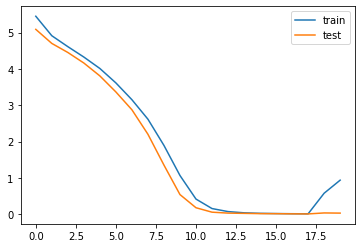

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [31]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [32]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [33]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 실제 결과와 요약문 비교

In [34]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == 0 or i == 'eostoken' or i == 'sostoken':  # 0, eostoken, sostoken은 제외
            continue
        temp += src_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("======================\n")

원문 : west bengal cm mamata banerjee said that pm narendra modi is misleading people about increasing the minimum support price of crops the centre has hiked the by only ãââ¹200 but claiming it has increased it by 50 banerjee said pm is saying the centre will double farmers income by already doubled our farmers income she further said 
실제 요약 : be guilty pakistans quarter his showing home pakistans quarter their years said 
예측 요약 :  farmers income by already our farmers income she further said

원문 : sonakshi sinha star opposite aditya roy kapur in karan johars upcoming production said i am up with him for the first im really looking forward to it the period drama film set in the will also star alia bhatt varun dhawan sanjay dutt and madhuri dixit it is scheduled to release on april 19 2019 
실제 요약 : germany suggested and will by statement to states on need coming launch 
예측 요약 :  sanjay and it is scheduled to release on april 19 2019

원문 : the supreme court has observed that delhi is gett

예측 요약 :  i just dont want to be involved in other she added

원문 : a study has claimed that fossils discovered in a nearly 35 rock in australia are the oldest fossils ever found and give the earliest direct evidence of life on earth however earlier studies on fossils from canada claimed to find remains of 377 and carbon in rocks giving rise to 
실제 요약 : it scoring bjp to continue ice of and in feel code to 
예측 요약 :  from canada claimed to find remains of and in giving rise

원문 : english premier league side former striker who from the coast has announced his retirement from professional football the 40yearold scored goals in appearances over two with chelsea helping them win the premier league four times and the champions league in 2012 won the premier league golden in and 
실제 요약 : and the done move in protests using the whether move in and 
예측 요약 :  and the champions league in 2012 won the premier league in

원문 : observing that six years have passed since the rape and murder case that th

예측 요약 :  and actress who will be playing the role of a lawyer

원문 : jawaharlal nehru universitys administration on friday reportedly restricted access to the youtube channels of media houses including the wire the hindu and ndtv among others students alleged content relating to student movements rahul gandhi kumar and arvind kejriwal was also blocked the restrictions were removed after 24 hours following pressure from students 
실제 요약 : he she the over hai as travel runs since france it talking 
예측 요약 :  and the were removed after 24 hours following pressure from students

원문 : a woman in madhya pradesh was allegedly forced to give birth in an condition inside a moving bus after she was denied an ambulance by a community hospital the doctors in the hospital had referred her to a district hospital but didnt provide any vehicle to take the woman in pain 
실제 요약 : researchers money world sent letter however forced to narendra the party in 
예측 요약 :  police hospital but didnt provide any vehi

# Summa을 이용한 추출적 요약

In [36]:
import requests
from summa.summarizer import summarize

In [37]:
text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [48]:
import urllib.request


urllib.request.urlretrieve('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv','text_sum')
data = pd.read_csv('text_sum',encoding='utf-8')


for i in range(0,100):
    text = data['text'][i]
    summary = data['headlines'][i]
    print(f"원문 : {text}\n")
    print(f"실제 요약 : {summary}\n")
    print(f"예측 요약 : {summarize(text,ratio=0.4)}\n")
    print("============================\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike

예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED

예측 요약 : Users get one CRED coin per rupee of bill

| 요약 방법 | 추상적 요약 | 추출적 요약 |
|---|---|---|
| 문법 완성도 측면| 문장이 어색할 수 있다. | 문장 내부에서 핵심 문장을 가져오는 것으로 판단. 비교적 어색하지 않다. |
| 핵심 단어 포함 측면 | 포함되는 경우가 많다. | 핵심 문장안에 핵심 단어가 없을 수 있다. |